# SENTIMENT ANALYSIS ON SOCIAL MEDIA POSTS

## Step 1 : Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bindu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bindu\AppData\Roaming\nltk_data...


True

In [2]:
df = pd.read_csv("Tweets.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

## Step 2: Keep only the relevant colums

In [7]:
df = df[['text', 'airline_sentiment']]
df = df.rename(columns={'text': 'post', 'airline_sentiment': 'sentiment'})
df.head()


,post,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


## Step 3: Text Preprocessing

We’ll:

Lowercase the text

Remove mentions (@username), URLs, special characters

Remove stopwords

Lemmatize the words

In [10]:
import nltk
nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bindu\AppData\Roaming\nltk_data...


True

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)         # remove URLs
    text = re.sub(r'@\w+|\#', '', text)                         # remove @mentions, hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)                     # remove punctuation and numbers
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_post'] = df['post'].apply(preprocess_text)
df[['post', 'cleaned_post']].head()


,post,cleaned_post
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing


## Step 4: Convert Text into Features (TF-IDF)

Now we’ll convert the cleaned text into numerical vectors using TF-IDF (Term Frequency-Inverse Document Frequency).

In [12]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_post']).toarray()


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   post          14640 non-null  object
 1   sentiment     14640 non-null  object
 2   cleaned_post  14640 non-null  object
dtypes: object(3)
memory usage: 343.2+ KB


In [14]:
print(X.shape)


(14640, 5000)


## Step 5: Encode Labels & Split Data

Convert sentiment labels (positive, neutral, negative) to numbers

Split data into training and testing sets

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode the sentiment labels
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])  # e.g., negative=0, neutral=1, positive=2

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Show encoded classes and shape info
print("Classes:", le.classes_)
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)


Classes: ['negative' 'neutral' 'positive']
Train set size: (11712, 5000)
Test set size: (2928, 5000)


In [18]:
df.head()

,post,sentiment,cleaned_post
0,@VirginAmerica What @dhepburn said.,neutral,said
1,@VirginAmerica plus you've added commercials t...,positive,plus youve added commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,neutral,didnt today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,negative,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,negative,really big bad thing


In [19]:
df['sentiment_encoded'] = le.transform(df['sentiment'])
df[['post', 'sentiment', 'sentiment_encoded']].head()


,post,sentiment,sentiment_encoded
0,@VirginAmerica What @dhepburn said.,neutral,1
1,@VirginAmerica plus you've added commercials t...,positive,2
2,@VirginAmerica I didn't today... Must mean I n...,neutral,1
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0


## Step 6: Train a Logistic Regression Model

In [20]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)


## Step 8: Evaluate the Model + Visualize with a Confusion Matrix

Print accuracy

Show classification report

 Plot a confusion matrix using Seaborn heatmap

Accuracy: 0.8002049180327869

Classification Report:

              precision    recall  f1-score   support

    negative       0.82      0.94      0.88      1889
     neutral       0.68      0.49      0.57       580
    positive       0.82      0.61      0.70       459

    accuracy                           0.80      2928
   macro avg       0.77      0.68      0.71      2928
weighted avg       0.79      0.80      0.79      2928



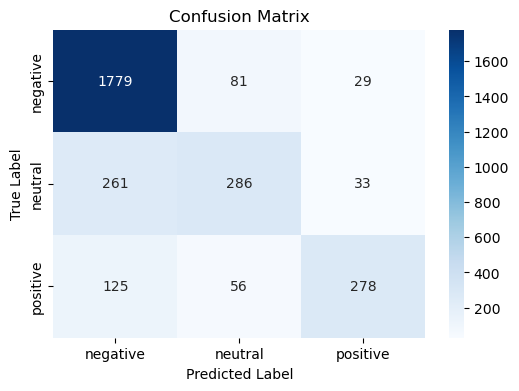

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix shows that:

Most negative tweets are correctly classified

Some neutral tweets are misclassified as negative or positive

Positive class performs decently, though could be better

## Step 9: Predict Sentiment for New Text

The model to predict sentiment for any custom input (like a real-world tweet).

In [22]:
def predict_sentiment(text):
    cleaned = preprocess_text(text)
    vector = tfidf.transform([cleaned])
    prediction = model.predict(vector)
    return le.inverse_transform(prediction)[0]

# Example predictions
print(predict_sentiment("I love this airline!"))
print(predict_sentiment("Worst flight experience ever."))
print(predict_sentiment("It was okay, nothing special."))


positive
negative
negative


In [23]:
import pickle

# Save model
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)


In [24]:
df['sentiment'].value_counts()


negative    9178
neutral     3099
positive    2363
Name: sentiment, dtype: int64

## Step 11: Handle Class Imbalance Using class_weight='balanced'

Your sentiment classes are imbalanced:

Negative: 9,178

Neutral: 3,099

Positive: 2,363

To address this, we’ll retrain Logistic Regression by telling it to weigh each class inversely proportional to its frequency.

In [25]:
from sklearn.linear_model import LogisticRegression

# Re-train logistic regression with balanced class weights
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Predict on test set again
y_pred = model.predict(X_test)


In [26]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.762636612021858

Classification Report:

              precision    recall  f1-score   support

    negative       0.90      0.79      0.84      1889
     neutral       0.52      0.67      0.58       580
    positive       0.68      0.75      0.71       459

    accuracy                           0.76      2928
   macro avg       0.70      0.74      0.71      2928
weighted avg       0.79      0.76      0.77      2928



In [27]:
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)
